In [ ]:

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
#from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


In [ ]:
file_path = "/content/drive/MyDrive/NGAsub_MegaFlatfile_RotD50_050_R211022_public.xlsx"
df = pd.read_excel(file_path)

In [ ]:
df.rename(columns={
    'PGA_g': 'pga',
    'Earthquake_Magnitude': 'mag',
    'Rjb_km': 'rjb',
    'Hypocenter_Depth_km': 'hypd',
    'Vs30_Selected_for_Analysis_m_s': 'vs30',
    'Intra_Inter_Flag': 'intra_inter',
    'Sensor_Depth_m': 'sensor_depth',
    'Multiple_Event': 'multi_event',
    'Late_P_trigger_flag_1ptYes_0ptNo': 'late_flag',
    'Source_review_flag': 'src_flag',
    'Longest_Usable_Period_for_PSa_Ave_Component_sec': 'tgm',
    'NGAsubEQID': 'EqID',
    'Station_Name':'siteID'

}, inplace=True)

df = df[(df['pga'] != -999) & (df['pga'] <= 10) & (df['mag'] >= 4)]

meta_cols = ['mag', 'rjb', 'hypd', 'vs30',"Ztor_km"]
for col in meta_cols:
    df = df[df[col] != -999]

df = df[df['intra_inter'].isin([0, 1, 5])]

is_interface = (df['intra_inter'] == 0) & (df['hypd'] < 40)
is_intraslab = (df['intra_inter'] == 1) & (df['hypd'] < 200)
df = df[is_interface | is_intraslab]

df = df[df['rjb'] <= 1000]

df = df[df['sensor_depth'] <= 2]

df = df[df['multi_event'] != 1]

df = df[df['late_flag'] != 1]

df = df[df['src_flag'].isin([0, 1, 2, 4])]

df = df[df['tgm'] >= 10]

event_counts = df['EqID'].value_counts()
valid_eids = event_counts[event_counts >= 3].index
df = df[df['EqID'].isin(valid_eids)]
df.shape


(14526, 227)

##1) Figures

###Magnitude vs Joyner-Boore distance

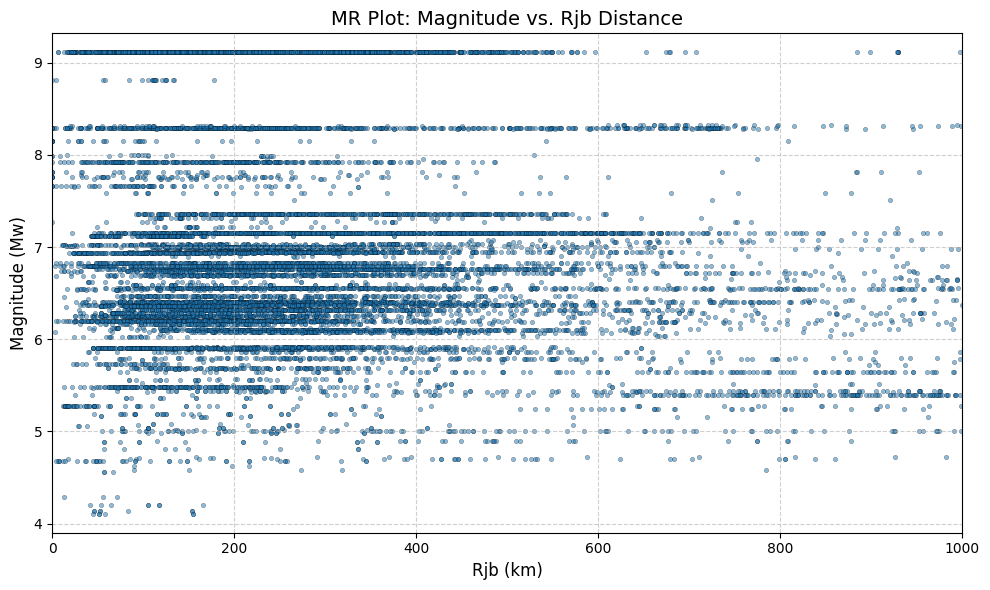

In [ ]:

import matplotlib.pyplot as plt

# Ensure 'mag' and 'rjb' are in the DataFrame
plt.figure(figsize=(10, 6))
plt.scatter(df['rjb'], df['mag'], s=10, alpha=0.5, edgecolors='k', linewidths=0.3)

plt.xlabel('Rjb (km)', fontsize=12)
plt.ylabel('Magnitude (Mw)', fontsize=12)
plt.title('MR Plot: Magnitude vs. Rjb Distance', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, 1000)
plt.ylim(df['mag'].min() - 0.2, df['mag'].max() + 0.2)
plt.tight_layout()
plt.show()

##2) histogram of each input parameter

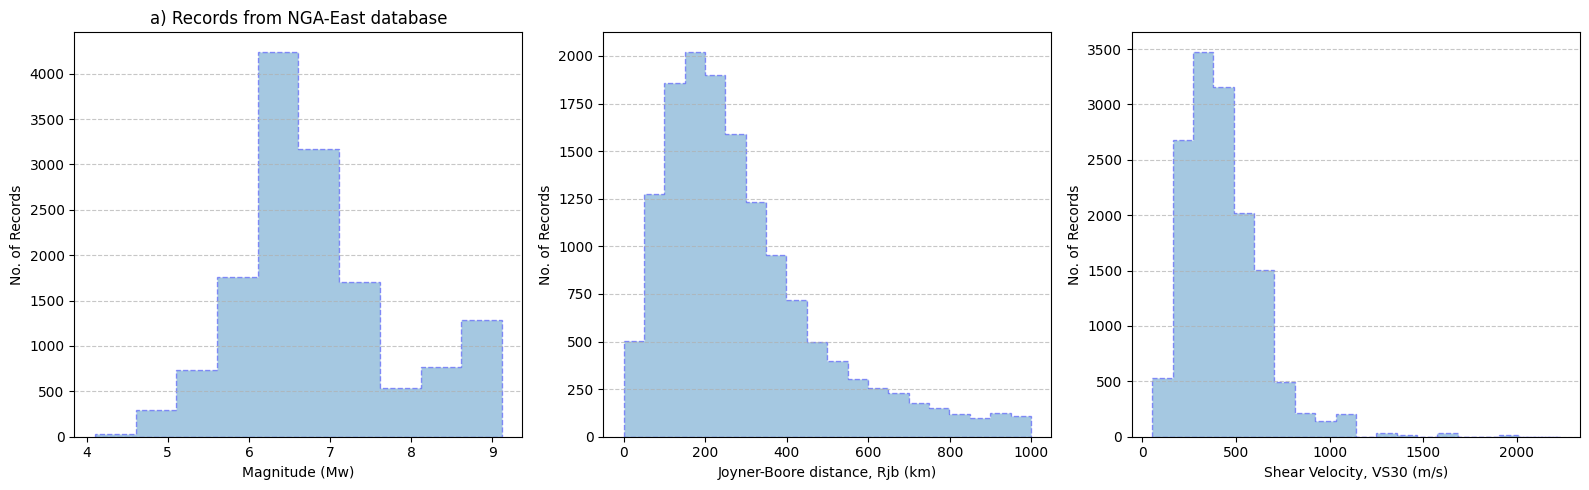

In [ ]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 3, figsize=(16, 5))

# 1. Histogram for Magnitude (mag)
axs[0].hist(df["mag"], bins=10, edgecolor='blue', linestyle='--', histtype='stepfilled', alpha=0.4)
axs[0].set_xlabel("Magnitude (Mw)")
axs[0].set_ylabel("No. of Records")
axs[0].set_title("a) Records from NGA-East database")
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# 2. Histogram for Joyner-Boore Distance (rjb)
axs[1].hist(df["rjb"], bins=20, edgecolor='blue', linestyle='--', histtype='stepfilled', alpha=0.4)
axs[1].set_xlabel("Joyner-Boore distance, Rjb (km)")
axs[1].set_ylabel("No. of Records")
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# 4. Histogram for VS30
axs[2].hist(df["vs30"], bins=20, edgecolor='blue', linestyle='--', histtype='stepfilled', alpha=0.4)
axs[2].set_xlabel("Shear Velocity, VS30 (m/s)")
axs[2].set_ylabel("No. of Records")
axs[2].grid(axis='y', linestyle='--', alpha=0.7)


# 3. Horizontal bar plot for Fault_Type
# Clean Fault_Type strings
# Convert 'Fault_Type' to string before applying .str.title()
#df["Fault_Type"] = df["Fault_Type"].astype(str).str.title() # Changed to convert to string
#fault_order = ["Strike Slip", "Normal", "Reverse", "Reverse Oblique"]
#fault_counts = df["Fault_Type"].value_counts().reindex(fault_order, fill_value=0)

#axs[3].barh(fault_counts.index, fault_counts.values, color='skyblue', edgecolor='blue', hatch='//')
#axs[3].set_xlabel("No. of Records")
#axs[3].invert_yaxis()
#axs[3].grid(axis='x', linestyle='--', alpha=0.7)

# Layout
plt.tight_layout()
plt.show()

Epoch 0, Loss: 0.3417
Epoch 10, Loss: 0.1905
Epoch 20, Loss: 0.1882
Epoch 30, Loss: 0.1768
Epoch 40, Loss: 0.1801
Epoch 50, Loss: 0.1737
Epoch 60, Loss: 0.1716
Epoch 70, Loss: 0.1701
Epoch 80, Loss: 0.1732
Epoch 90, Loss: 0.1702
Epoch 100, Loss: 0.1715
Epoch 110, Loss: 0.1703
Epoch 120, Loss: 0.1682
Epoch 130, Loss: 0.1678
Epoch 140, Loss: 0.1665
Epoch 150, Loss: 0.1675
Epoch 160, Loss: 0.1657
Epoch 170, Loss: 0.1653
Epoch 180, Loss: 0.1644
Epoch 190, Loss: 0.1664
Epoch 200, Loss: 0.1650
Epoch 210, Loss: 0.1643
Epoch 220, Loss: 0.1647
Epoch 230, Loss: 0.1643
Epoch 240, Loss: 0.1643
Epoch 250, Loss: 0.1641
Epoch 260, Loss: 0.1647
Epoch 270, Loss: 0.1616
Epoch 280, Loss: 0.1633
Epoch 290, Loss: 0.1633
Overall R² Score: 0.8565
No interface records found in the test set.
No intraslab records found in the test set.


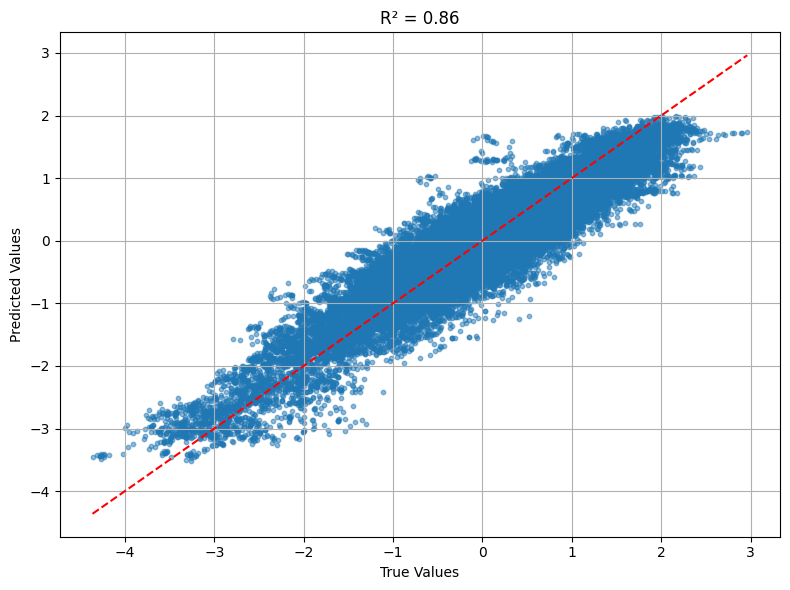

In [ ]:
import numpy as np

input_cols = ['mag', 'rjb', 'logrjb', 'logvs30', 'intra_inter']
target_cols = [
    "T0pt010S", "T0pt020S", "T0pt030S", "T0pt050S", "T0pt075S",
    "T0pt100S", "T0pt150S", "T0pt200S", "T0pt300S", "T0pt400S",
    "T0pt500S", "T0pt750S", "T1pt000S", "T1pt500S", "T2pt000S",
    "T2pt500S", "T3pt000S", "T3pt500S", "T4pt000S", "T5pt000S"
]

df['rjb'] = df['rjb'].replace(0, 0.01).replace([np.inf, -np.inf], np.nan)
df['vs30'] = df['vs30'].astype(float).replace(0, 0.01).replace([np.inf, -np.inf], np.nan)

# Log-transform rjb and vs30
df['logrjb'] = np.log10(df['rjb'])
df['logvs30'] = np.log10(df['vs30'])

# Drop any rows with NaN
df = df.dropna(subset=input_cols + target_cols)

# Extract inputs and targets
inputs = df[input_cols].values
targets = df[target_cols].values

# >>>>> Correct: Apply natural log to targets <<<<<
targets = np.log(targets)

# Normalize inputs and targets separately
scaler_input = StandardScaler()
scaler_target = StandardScaler()

inputs_scaled = scaler_input.fit_transform(inputs)
targets_scaled = scaler_target.fit_transform(targets)

# Save EqID and SiteID for residual calculations
EqIDs = df['EqID'].values
siteIDs = df['siteID'].values

from sklearn.model_selection import train_test_split

# Stratify on intra_inter (last column in input)
X_train, X_temp, y_train, y_temp, EqID_train, EqID_temp, siteID_train, siteID_temp = train_test_split(
    inputs_scaled, targets_scaled, EqIDs, siteIDs, test_size=0.3, random_state=42, stratify=inputs_scaled[:, -1])

X_val, X_test, y_val, y_test, EqID_val, EqID_test, siteID_val, siteID_test = train_test_split(
    X_temp, y_temp, EqID_temp, siteID_temp, test_size=0.5, random_state=42, stratify=X_temp[:, -1])


# This code adds epistemic and aleatory uncertainty estimation to the BNN model,
# and separately computes R² for inter-event and intra-event records.

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
Y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Custom Bayesian Linear Layer
class CustomBayesLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(CustomBayesLinear, self).__init__()
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / np.sqrt(self.weight_mu.size(1))
        self.weight_mu.data.uniform_(-stdv, stdv)
        self.weight_rho.data.fill_(-5)
        self.bias_mu.data.uniform_(-stdv, stdv)
        self.bias_rho.data.fill_(-5)

    def forward(self, x):
        epsilon_w = torch.randn_like(self.weight_mu)
        epsilon_b = torch.randn_like(self.bias_mu)
        weight_sigma = torch.log1p(torch.exp(self.weight_rho))
        bias_sigma = torch.log1p(torch.exp(self.bias_rho))
        weight = self.weight_mu + weight_sigma * epsilon_w
        bias = self.bias_mu + bias_sigma * epsilon_b
        return F.linear(x, weight, bias)

# BNN Model
class BNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(BNN, self).__init__()
        self.fc1 = CustomBayesLinear(in_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = CustomBayesLinear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = CustomBayesLinear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.25)
        self.out = CustomBayesLinear(128, out_dim)

    def forward(self, x):
        x = self.dropout(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout(F.relu(self.bn2(self.fc2(x))))
        x = self.dropout(F.relu(self.bn3(self.fc3(x))))
        return self.out(x)

# Initialize and train model
model = BNN(X_train.shape[1], y_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=64, shuffle=True)

def train(model, loader, epochs=300):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss / len(loader):.4f}")

train(model, train_loader)

# Prediction with uncertainty
def predict_with_uncertainty(model, X, samples=100):
    model.eval()
    preds = []
    with torch.no_grad():
        for _ in range(samples):
            preds.append(model(X).cpu().numpy())
    preds = np.stack(preds)
    epistemic = np.std(preds, axis=0)
    aleatory = np.mean((preds - preds.mean(axis=0))**2, axis=0)
    return torch.tensor(preds.mean(axis=0)), torch.tensor(epistemic), torch.tensor(aleatory)

mean_pred, epistemic_unc, aleatory_unc = predict_with_uncertainty(model, X_test_tensor)
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


# R² Score
overall_r2 = r2_score(Y_test_tensor.numpy(), mean_pred.numpy(), multioutput='uniform_average')
print(f"Overall R² Score: {overall_r2:.4f}")

# Separate R² for interface (0) and intraslab (1)
test_labels = X_test[:, -1]

# Check if there are any interface or intraslab records
interface_records = Y_test_tensor.numpy()[test_labels == 0]
intraslab_records = Y_test_tensor.numpy()[test_labels == 1]

if interface_records.size > 0:  # Calculate R² only if there are interface records
    r2_interface = r2_score(interface_records, mean_pred.numpy()[test_labels == 0])
    print(f"Interface R²: {r2_interface:.4f}")
else:
    print("No interface records found in the test set.")

if intraslab_records.size > 0:  # Calculate R² only if there are intraslab records
    r2_intraslab = r2_score(intraslab_records, mean_pred.numpy()[test_labels == 1])
    print(f"Intraslab R²: {r2_intraslab:.4f}")
else:
    print("No intraslab records found in the test set.")


# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(Y_test_tensor.numpy(), mean_pred.numpy(), alpha=0.5, s=10)
plt.plot([Y_test_tensor.min(), Y_test_tensor.max()],
         [Y_test_tensor.min(), Y_test_tensor.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"R² = {overall_r2:.2f}")
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# Save model state
torch.save(model.state_dict(), "bnn_model.pth")

##6) Ground Motion Physics

###a- Spectral Acceleration vs Time Period at different Magnitudes

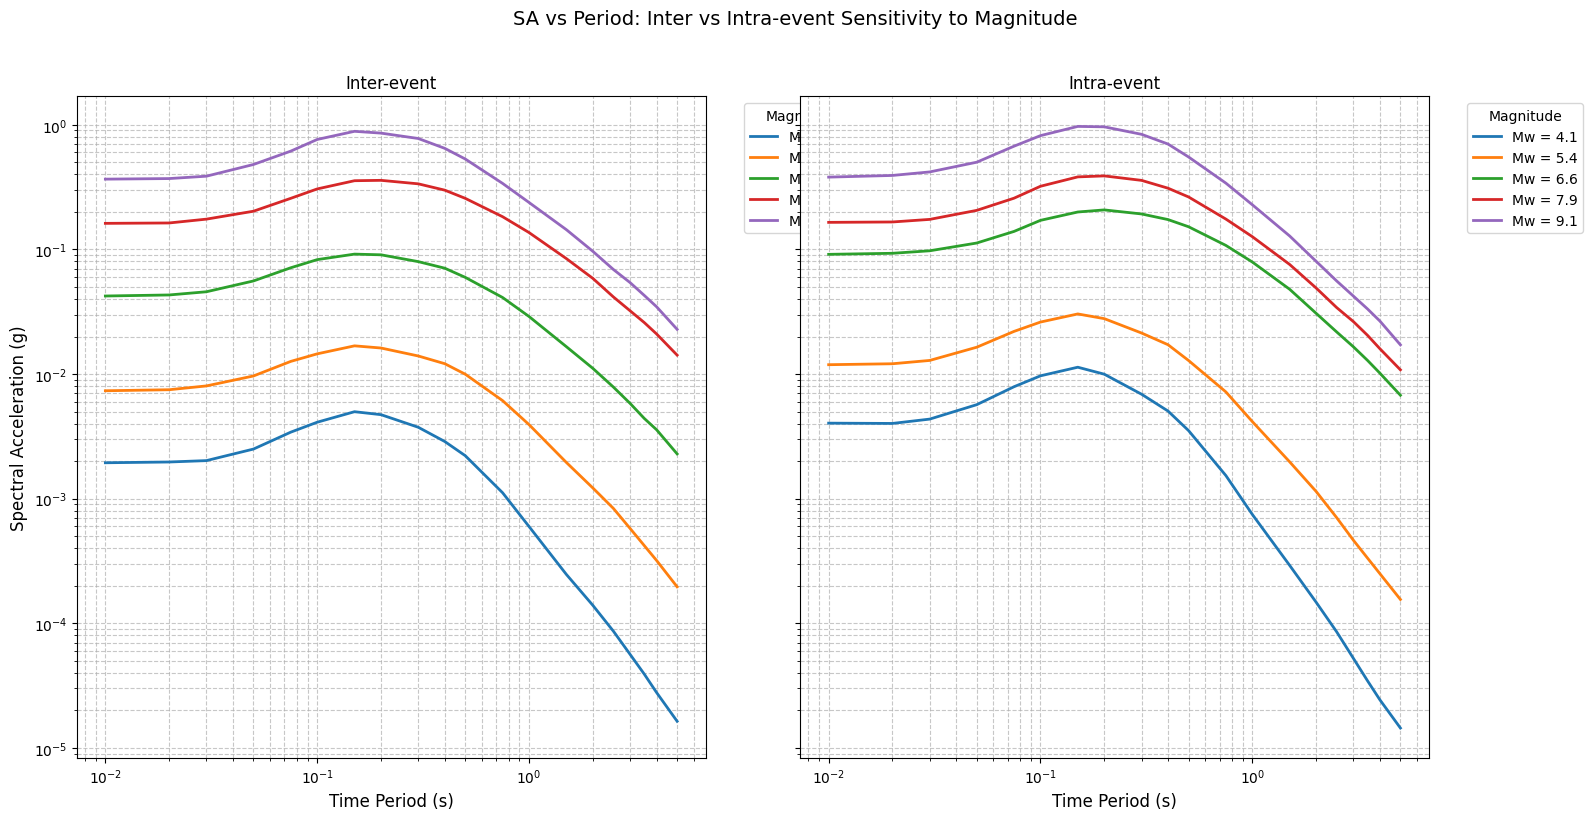

In [ ]:
import torch

# Convert periods
periods = [float(t[1:].replace("pt", ".").replace("S", "")) for t in target_cols]

# Fixed values
fixed_rjb = 10.0
fixed_vs30 = 760.0
logrjb = np.log10(max(fixed_rjb, 0.01))
logvs30 = np.log10(max(fixed_vs30, 0.01))

# Mw range from data
mw_range = np.linspace(df['mag'].min(), df['mag'].max(), 5)

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Load the saved model
loaded_model = BNN(X_train.shape[1], y_train.shape[1])  # Create a new instance of your model
loaded_model.load_state_dict(torch.load("bnn_model.pth")) # Load the saved state dictionary
loaded_model.eval() # Set the model to evaluation mode


for idx, intra_inter_val in enumerate([0, 1]):
    ax = axes[idx]
    for mw in mw_range:
        X_input = np.array([[mw, fixed_rjb, logrjb, logvs30, intra_inter_val]])
        X_scaled = scaler_input.transform(X_input)
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

        # Sample predictions from BNN
        predictions = []
        num_samples = 100
        for _ in range(num_samples):
            with torch.no_grad():
                # Use the loaded model for prediction
                y_pred_scaled = loaded_model(X_tensor).numpy()
                predictions.append(y_pred_scaled)


        predictions = np.array(predictions)  # Shape: (100, 1, num_outputs)
        mean_pred_scaled = predictions.mean(axis=0).squeeze()
        y_pred_log = scaler_target.inverse_transform(mean_pred_scaled.reshape(1, -1))
        y_pred = np.exp(y_pred_log).flatten()

        label = f'Mw = {mw:.1f}'
        ax.semilogy(periods, y_pred, label=label, linewidth=2)

    ax.set_title("Inter-event" if intra_inter_val == 0 else "Intra-event", fontsize=12)
    ax.set_xlabel("Time Period (s)", fontsize=12)
    ax.grid(True, which="both", linestyle='--', alpha=0.7)
    ax.set_xscale('log')

    if idx == 0:
        ax.set_ylabel("Spectral Acceleration (g)", fontsize=12)

    ax.legend(title="Magnitude", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle("SA vs Period: Inter vs Intra-event Sensitivity to Magnitude", fontsize=14, y=1.02)
plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
plt.show()


###6b- Spectral Acceleration vs Time Period at different Joyner-Boore distance

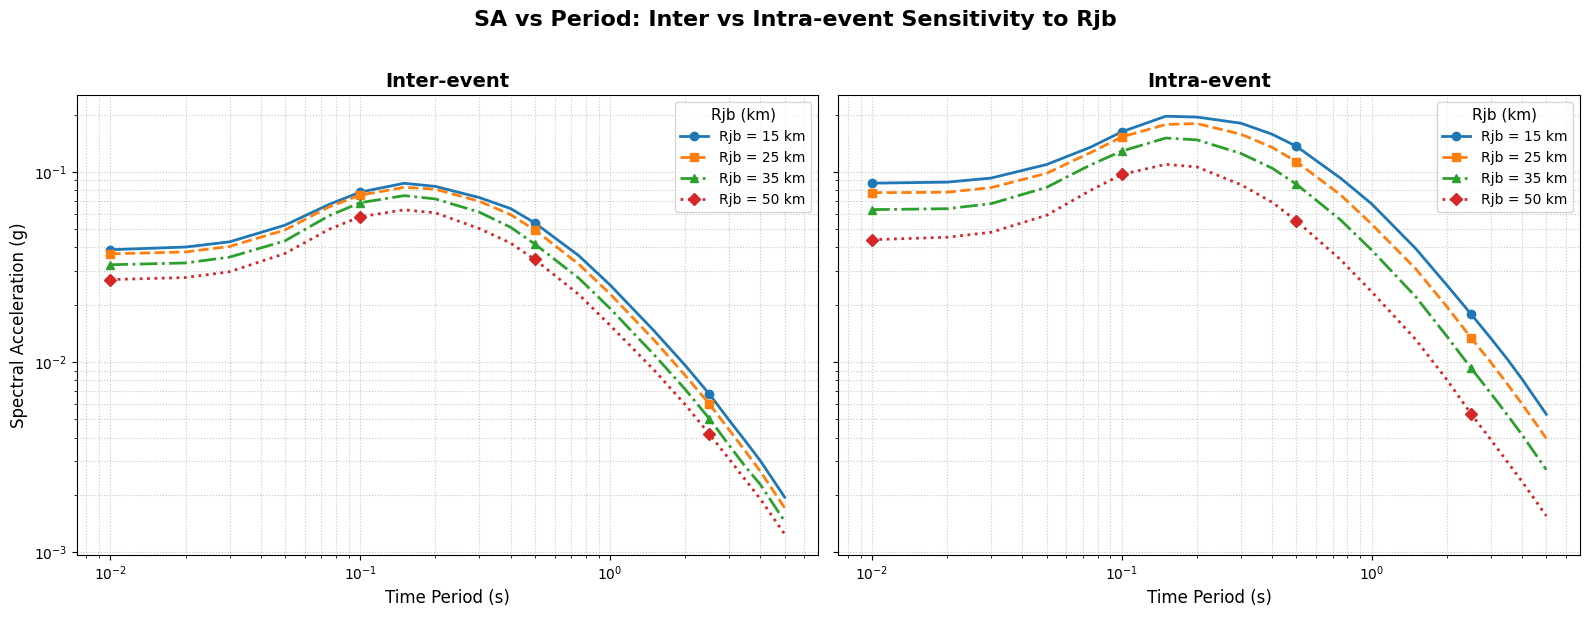

In [ ]:
import torch

# Convert periods
periods = [float(t[1:].replace("pt", ".").replace("S", "")) for t in target_cols]

# Fixed values
fixed_mw = 6.5
fixed_vs30 = 760.0
logvs30 = np.log10(max(fixed_vs30, 0.01))

# Rjb values to test
rjb_values = [15, 25, 35, 50]
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

model.eval()

for idx, intra_inter_val in enumerate([0, 1]):
    ax = axes[idx]
    for i, rjb in enumerate(rjb_values):
        logrjb = np.log10(max(rjb, 0.01))
        X_input = np.array([[fixed_mw, rjb, logrjb, logvs30, intra_inter_val]])
        X_scaled = scaler_input.transform(X_input)
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

        # Sample predictions from BNN
        predictions = []
        num_samples = 100
        for _ in range(num_samples):
            with torch.no_grad():
                y_pred_scaled = model(X_tensor).numpy()
                predictions.append(y_pred_scaled)

        predictions = np.array(predictions)  # Shape: (100, 1, num_outputs)
        mean_pred_scaled = predictions.mean(axis=0).squeeze()
        y_pred_log = scaler_target.inverse_transform(mean_pred_scaled.reshape(1, -1))
        y_pred = np.exp(y_pred_log).flatten()

        label = f'Rjb = {rjb} km'
        ax.plot(periods, y_pred,
                linestyle=line_styles[i % len(line_styles)],
                marker=markers[i % len(markers)],
                markevery=5,
                linewidth=2,
                label=label)

    ax.set_title("Inter-event" if intra_inter_val == 0 else "Intra-event", fontsize=14, weight='bold')
    ax.set_xlabel("Time Period (s)", fontsize=12)
    ax.grid(True, which='both', linestyle=':', alpha=0.7)
    if idx == 0:
        ax.set_ylabel("Spectral Acceleration (g)", fontsize=12)
    ax.legend(title="Rjb (km)", fontsize=10, title_fontsize=11)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.tick_params(axis='both', which='major', labelsize=10)

plt.suptitle("SA vs Period: Inter vs Intra-event Sensitivity to Rjb", fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.show()


###6c- Spectral Acceleration vs Time Period at different Average Shear-Wave Velocities of the ground within the top 30 meters

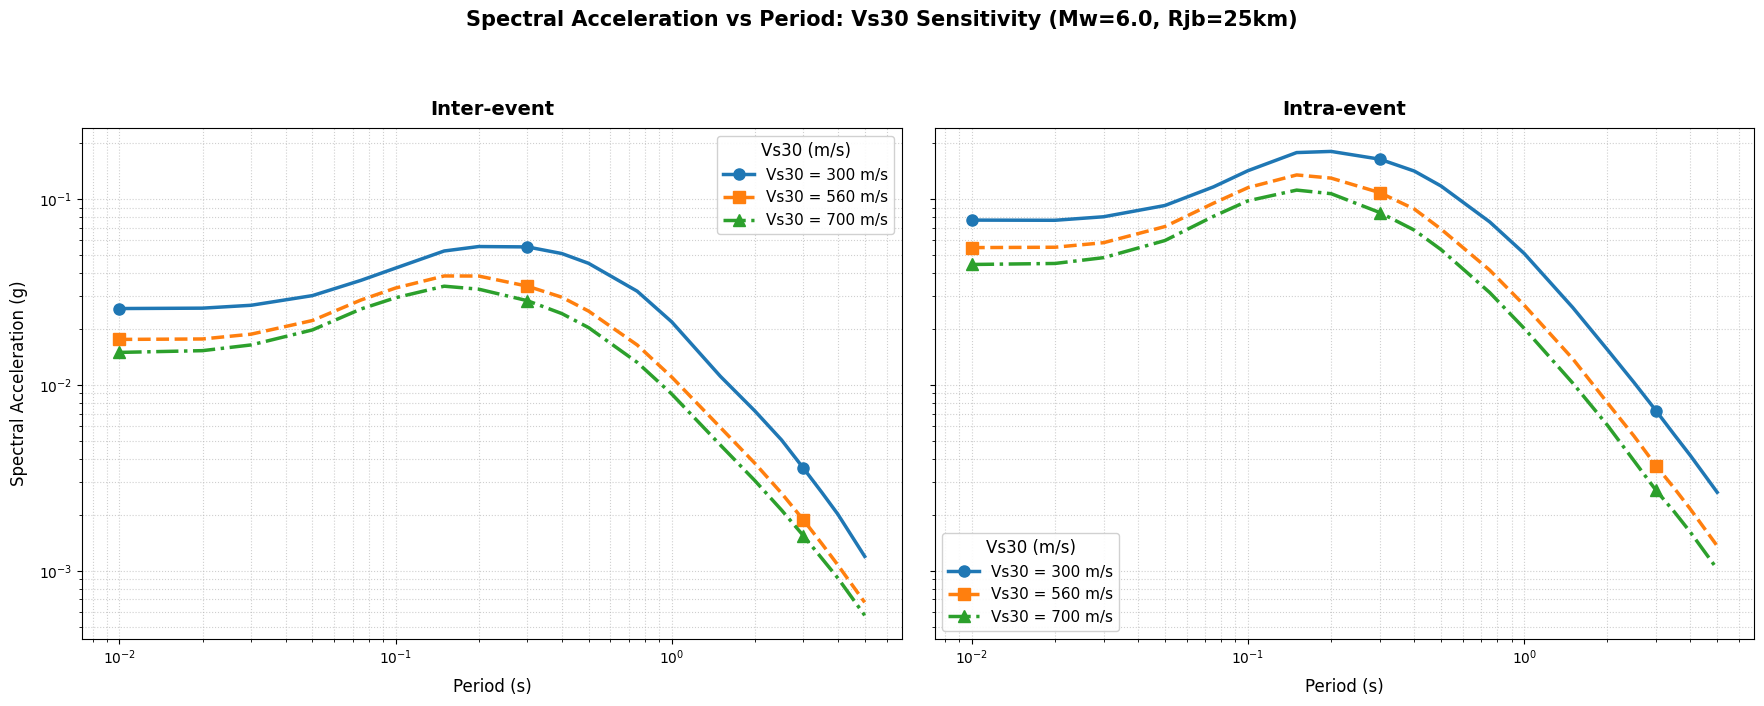

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

fixed_mw = 6.0
fixed_rjb = 25.0
logrjb = np.log10(max(fixed_rjb, 0.01))

vs30_values = [300, 560, 700]

styles = {
    300: {'color': '#1f77b4', 'linestyle': '-', 'marker': 'o', 'linewidth': 2.5},
    560: {'color': '#ff7f0e', 'linestyle': '--', 'marker': 's', 'linewidth': 2.5},
    700: {'color': '#2ca02c', 'linestyle': '-.', 'marker': '^', 'linewidth': 2.5},
}

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

model.eval()

for idx, intra_inter_val in enumerate([0, 1]):
    ax = axes[idx]

    for vs30 in vs30_values:
        logvs30 = np.log10(max(vs30, 0.01))
        X_input = np.array([[fixed_mw, fixed_rjb, logrjb, logvs30, intra_inter_val]])
        X_scaled = scaler_input.transform(X_input)
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

        # Sample multiple predictions from the BNN
        predictions = []
        num_samples = 100
        for _ in range(num_samples):
            with torch.no_grad():
                y_pred_scaled = model(X_tensor).numpy()
                predictions.append(y_pred_scaled)

        predictions = np.array(predictions)  # Shape: (100, 1, num_outputs)
        mean_pred_scaled = predictions.mean(axis=0).squeeze()  # (num_outputs,)
        y_pred_log = scaler_target.inverse_transform(mean_pred_scaled.reshape(1, -1))
        y_pred = np.exp(y_pred_log).flatten()

        ax.plot(periods, y_pred,
                label=f'Vs30 = {vs30} m/s',
                **styles[vs30],
                markersize=8,
                markevery=8)

    ax.set_title("Inter-event" if intra_inter_val == 0 else "Intra-event",
                 fontsize=14, pad=10, weight='bold')
    ax.set_xlabel("Period (s)", fontsize=12, labelpad=8)
    ax.grid(True, which='both', linestyle=':', alpha=0.6)

    if idx == 0:
        ax.set_ylabel("Spectral Acceleration (g)", fontsize=12, labelpad=8)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.legend(title="Vs30 (m/s)",
              fontsize=11,
              title_fontsize=12,
              framealpha=0.9,
              loc='upper right' if intra_inter_val == 0 else 'lower left')

plt.suptitle("Spectral Acceleration vs Period: Vs30 Sensitivity (Mw=6.0, Rjb=25km)",
             fontsize=15, weight='bold', y=1.02)
plt.tight_layout(pad=2.0)
plt.show()


##7) Ground motion physics wrt Rjb

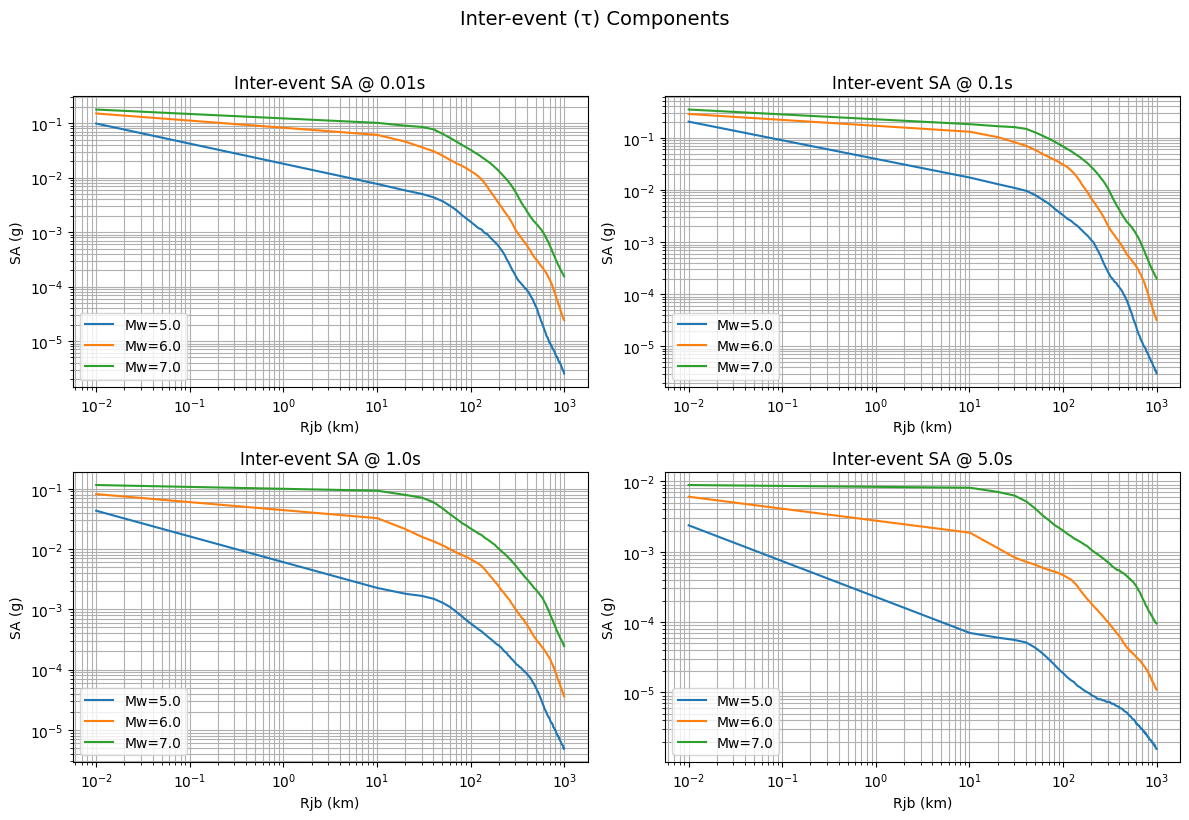

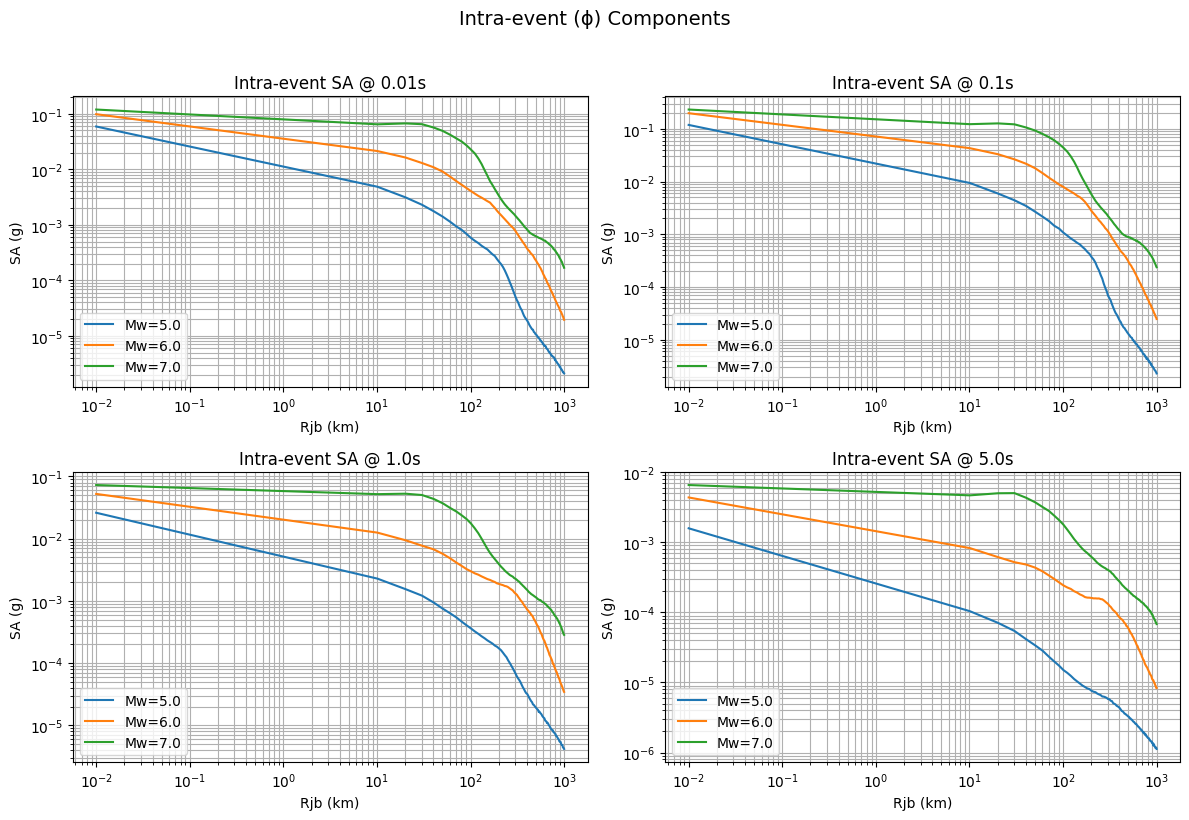

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

selected_period_indices = [0, 5, 12, 19]
selected_periods = [float(target_cols[i][1:].replace('pt', '.').replace('S', '')) for i in selected_period_indices]

rjb_range = np.linspace(df['rjb'].min(), df['rjb'].max(), 100)
mw_values = [5.0, 6.0, 7.0]
fixed_vs30 = 760
logvs30 = np.log10(fixed_vs30)

def get_bnn_prediction(X_input, iT, num_samples=100):
    X_scaled = scaler_input.transform(X_input)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

    preds = []
    model.eval()
    for _ in range(num_samples):
        with torch.no_grad():
            y_pred_scaled = model(X_tensor).numpy()
        preds.append(y_pred_scaled)

    preds = np.array(preds)  # shape (num_samples, 1, num_outputs)
    mean_pred = preds.mean(axis=0).squeeze()  # shape (num_outputs,)
    y_pred_log = scaler_target.inverse_transform(mean_pred.reshape(1, -1))
    return np.exp(y_pred_log[0, iT])  # scalar

# ================================
# 1. Inter-event (τ) Components
# ================================
plt.figure(figsize=(12, 8))
for idx, iT in enumerate(selected_period_indices):
    plt.subplot(2, 2, idx + 1)

    for mw in mw_values:
        sa_values = []
        for rjb in rjb_range:
            logrjb = np.log10(rjb)
            X_input = np.array([[mw, rjb, logrjb, logvs30, 1]])  # 1 for inter-event
            sa = get_bnn_prediction(X_input, iT)
            sa_values.append(sa)

        #plt.semilogy(rjb_range, sa_values, label=f'Mw={mw}')
        plt.plot(rjb_range, sa_values, label=f'Mw={mw}')
        plt.xscale("log")
        plt.yscale("log")


    plt.xlabel("Rjb (km)")
    plt.ylabel("SA (g)")
    plt.title(f"Inter-event SA @ {selected_periods[idx]}s")
    plt.grid(True, which="both", ls="-")
    plt.legend()

plt.suptitle("Inter-event (τ) Components", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ================================
# 2. Intra-event (ϕ) Components
# ================================
plt.figure(figsize=(12, 8))
for idx, iT in enumerate(selected_period_indices):
    plt.subplot(2, 2, idx + 1)

    for mw in mw_values:
        sa_values = []
        for rjb in rjb_range:
            logrjb = np.log10(rjb)
            X_input = np.array([[mw, rjb, logrjb, logvs30, 0]])  # 0 for intra-event
            sa = get_bnn_prediction(X_input, iT)
            sa_values.append(sa)

        #plt.semilogy(rjb_range, sa_values, label=f'Mw={mw}')
        plt.plot(rjb_range, sa_values, label=f'Mw={mw}')
        plt.xscale("log")
        plt.yscale("log")


    plt.xlabel("Rjb (km)")
    plt.ylabel("SA (g)")
    plt.title(f"Intra-event SA @ {selected_periods[idx]}s")
    plt.grid(True, which="both", ls="-")
    plt.legend()

plt.suptitle("Intra-event (ϕ) Components", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


##8) SHAP Analysis

Random time period selected: 1.624 seconds


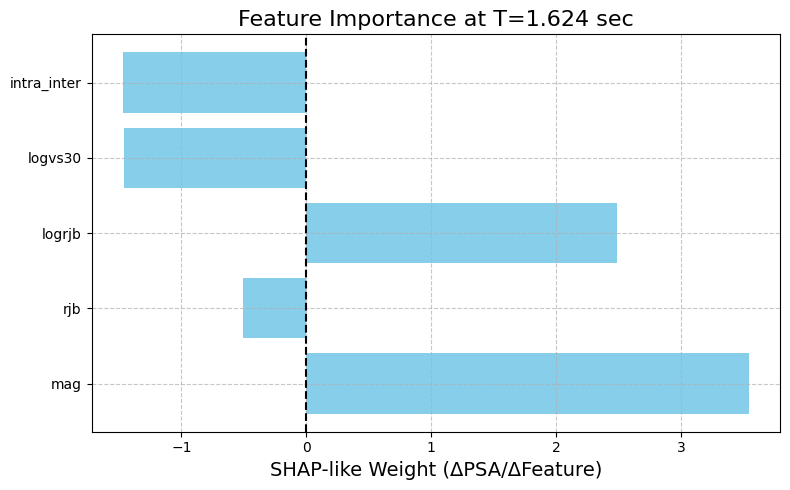

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import random

# Assume your input columns are like this
input_cols = ['mag', 'rjb', 'logrjb', 'logvs30', 'intra_inter']

# Predict for training samples
model.eval()
X_train = []
for idx in df[input_cols].dropna().index:
    # Use inputs_scaled instead of X
    X_train.append(inputs_scaled[df[input_cols].dropna().index.get_loc(idx)])

X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32)

# Predict
preds = []
with torch.no_grad():
    for _ in range(100):
        preds.append(model(X_train_tensor).cpu().numpy())

preds = np.stack(preds)
mean_preds = preds.mean(axis=0)  # shape: (N_samples, N_periods)

# Choose random time period index
t = np.logspace(-2, 1, mean_preds.shape[1])
random_idx = np.random.randint(0, len(t))
random_period = t[random_idx]

print(f"Random time period selected: {random_period:.3f} seconds")

# Now compute pseudo-SHAP values
# Idea: perturb each feature slightly, and see impact on output
epsilon = 1e-2  # Small perturbation

feature_importances = []

# Calculate feature importance for all features in input_cols
for feature_idx in range(len(input_cols)):  # Iterate over all features
    X_perturbed = X_train_tensor.clone()
    X_perturbed[:, feature_idx] += epsilon

    with torch.no_grad():
        preds_perturbed = model(X_perturbed).cpu().numpy()

    preds_perturbed_mean = preds_perturbed.mean(axis=0)

    # Difference in prediction at selected time period
    delta = preds_perturbed_mean[random_idx] - mean_preds[:, random_idx].mean()

    feature_importances.append(delta / epsilon)  # approximate derivative

# Plotting
features = ['mag', 'rjb', 'logrjb', 'logvs30', 'intra_inter']  # Use all features

plt.figure(figsize=(8, 5))
plt.barh(features, feature_importances, color='skyblue') # Now features and feature_importances have the same length
plt.axvline(0, color='black', linestyle='--')
plt.xlabel("SHAP-like Weight (ΔPSA/ΔFeature)", fontsize=14)
plt.title(f"Feature Importance at T={random_period:.3f} sec", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

##9) Relative Importance Plot

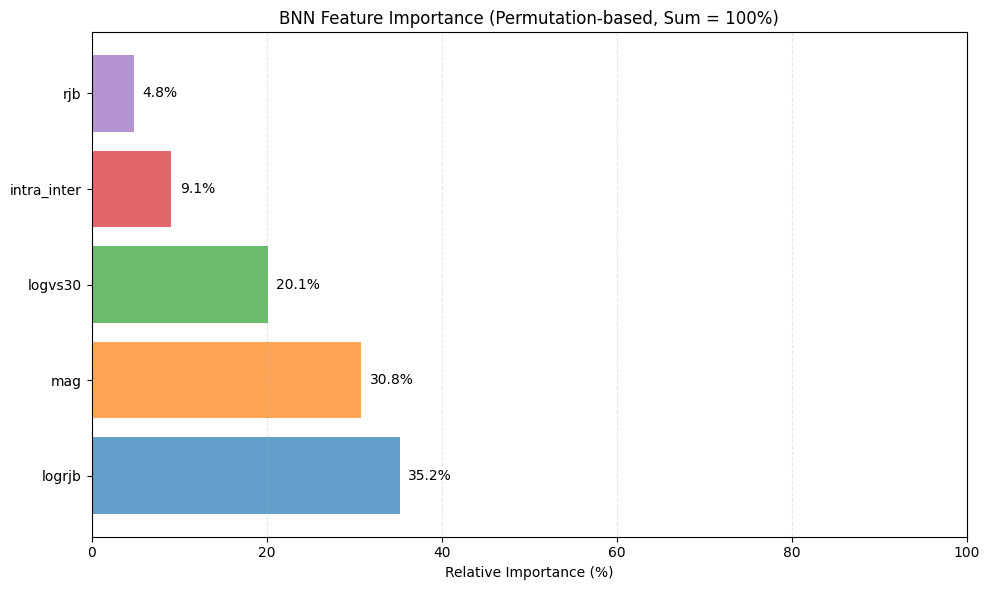

In [ ]:
def bnn_scoring_fn(model, X, y, scaler_input, scaler_target):
    """
    Custom scoring function for BNN.
    Returns the mean MSE over all outputs (periods).
    """
    X_scaled = scaler_input.transform(X)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_tensor).numpy()

    # Inverse scale
    y_pred = scaler_target.inverse_transform(y_pred_scaled)
    y_true = scaler_target.inverse_transform(y)

    mse_per_period = np.mean((y_true - y_pred) ** 2, axis=0)
    return np.mean(mse_per_period)


def compute_permutation_importance_bnn(model, X_val, y_val, input_cols, scaler_input, scaler_target, n_repeats=10):
    baseline_score = bnn_scoring_fn(model, X_val, y_val, scaler_input, scaler_target)
    importances = np.zeros(len(input_cols))

    for i in range(len(input_cols)):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X_val.copy()
            np.random.shuffle(X_permuted[:, i])  # Shuffle only column i
            score = bnn_scoring_fn(model, X_permuted, y_val, scaler_input, scaler_target)
            scores.append(score)
        importances[i] = np.mean(scores) - baseline_score

    # Normalize
    total_importance = np.sum(np.abs(importances))
    normalized = np.round((importances / total_importance) * 100, 1)
    normalized[-1] += 100 - np.round(np.sum(normalized), 1)

    return normalized


# Compute permutation importance for BNN
normalized_importance = compute_permutation_importance_bnn(
    model, X_val, y_val, input_cols, scaler_input, scaler_target, n_repeats=10
)

# Sorting
sorted_idx = np.argsort(normalized_importance)[::-1]
sorted_features = np.array(input_cols)[sorted_idx]
sorted_importance = normalized_importance[sorted_idx]

# Plotting
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10.colors
bars = plt.barh(range(len(sorted_features)), sorted_importance, color=colors, alpha=0.7)

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height() / 2,
             f"{width:.1f}%", va='center', ha='left')

plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlim(0, 100)
plt.xlabel("Relative Importance (%)")
plt.title("BNN Feature Importance (Permutation-based, Sum = 100%)")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


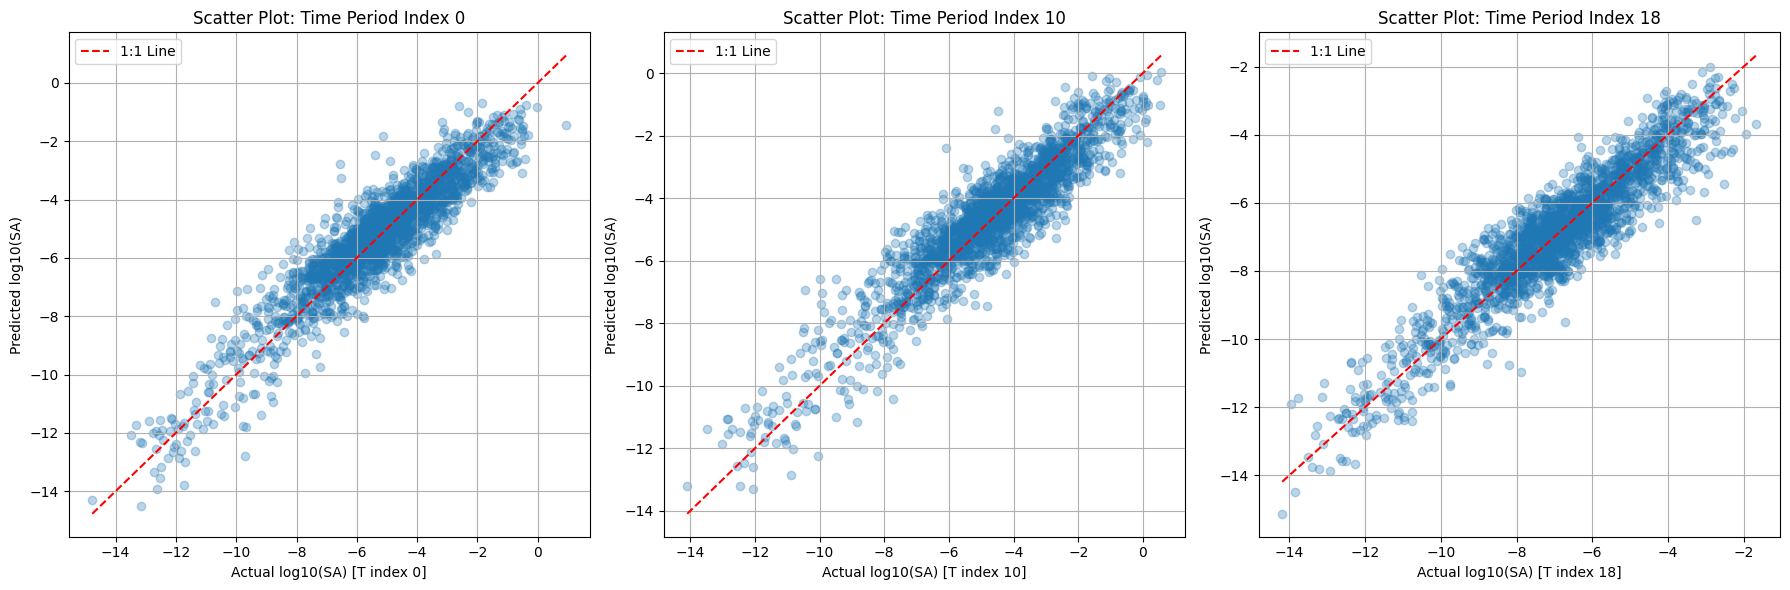

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch  # Import torch

spectral_indices = [0, 10, 18]

# Get original log-space values (no exp if already in log)
Y_test_log = scaler_target.inverse_transform(y_test)

# Convert X_train to a numpy array
X_train = np.array(X_train)
# Convert X_test to a numpy array
X_test = np.array(X_test)

model = BNN(X_train.shape[1], y_train.shape[1])  # Re-initialize the model
model.load_state_dict(torch.load("bnn_model.pth"))  # Load saved state

# Make predictions using the loaded model
Y_pred_scaled = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()  # Convert X_test to tensor and detach from graph

Y_pred_log = scaler_target.inverse_transform(Y_pred_scaled)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, idx in enumerate(spectral_indices):
    ax = axs[i]
    ax.scatter(Y_test_log[:, idx], Y_pred_log[:, idx], alpha=0.3)
    ax.plot([Y_test_log[:, idx].min(), Y_test_log[:, idx].max()],
            [Y_test_log[:, idx].min(), Y_test_log[:, idx].max()], 'r--', label='1:1 Line')

    ax.set_xlabel(f'Actual log10(SA) [T index {idx}]')
    ax.set_ylabel('Predicted log10(SA)')
    ax.set_title(f'Scatter Plot: Time Period Index {idx}')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

##5) Error bar Plots

<ipython-input-48-285302e8953d>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df_plot.groupby('bin')['x'].mean() # Changed df to df_plot
<ipython-input-48-285302e8953d>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df_plot.groupby('bin')['y'].mean() # Changed df to df_plot
<ipython-input-48-285302e8953d>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stds = df_plot.groupby('bin')[

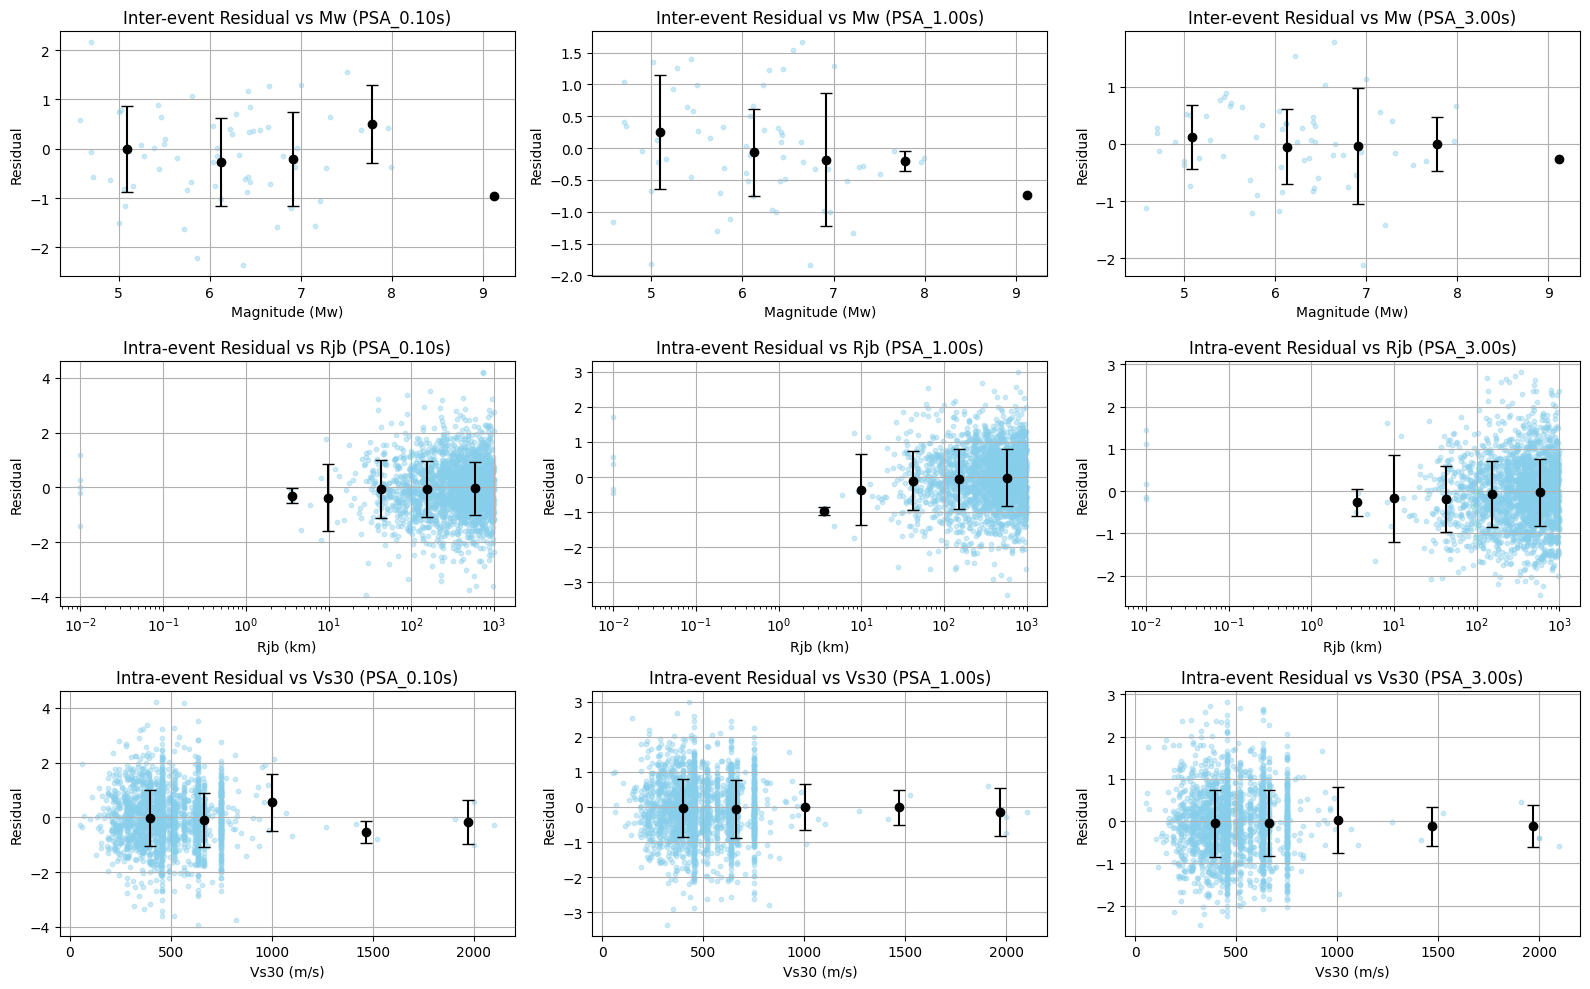

In [ ]:
time_periods = [0.01, 0.02, 0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4,
                0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0]

selected_indices = [5, 12, 16]  # Modify based on your period selection
selected_labels = [f"PSA_{time_periods[i]:.2f}s" for i in selected_indices]

# Plotting function with binned mean/std
def plot_residual_binned(x, y, xlabel, title, log_x=False, bins=6, ax=None):
    df_plot = pd.DataFrame({'x': x, 'y': y}) # Changed df to df_plot to avoid name conflict
    df_plot['bin'] = pd.cut(df_plot['x'], bins=bins) # Changed df to df_plot

    bin_centers = df_plot.groupby('bin')['x'].mean() # Changed df to df_plot
    bin_means = df_plot.groupby('bin')['y'].mean() # Changed df to df_plot
    bin_stds = df_plot.groupby('bin')['y'].std() # Changed df to df_plot

    if ax is None:
        ax = plt.gca()
    ax.scatter(x, y, alpha=0.4, s=10, color='skyblue')
    ax.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='o', color='black', capsize=4)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Residual")
    ax.set_title(title)
    if log_x:
        ax.set_xscale("log")
    ax.grid(True)

# Assuming 'model' is your trained BNN model
# Get predictions on the test set
Y_pred_scaled = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()
Y_pred_log = scaler_target.inverse_transform(Y_pred_scaled)  # Inverse transform to log space

# Calculate residuals in log space
residuals_log = Y_test_log - Y_pred_log

# Separate inter-event and intra-event residuals
# Get unique EqIDs and their indices in the test set
eq_unique, eq_idx_original = np.unique(EqIDs, return_index=True)
# Filter eq_idx_original to be within the bounds of residuals_log
eq_idx = [idx for idx in eq_idx_original if idx < residuals_log.shape[0]]
inter_event = residuals_log[eq_idx]  # Inter-event residuals
intra_event = residuals_log  # All residuals (including intra-event)

# Plot setup
fig, axs = plt.subplots(3, 3, figsize=(16, 10))

for col, i in enumerate(selected_indices):
    # Inter-event vs Mw
    Mw_vals = df['mag'].values[eq_idx_original]  # assuming 'mag' is moment magnitude
    # Filter Mw_vals to match the filtered eq_idx
    Mw_vals_filtered = Mw_vals[np.array(eq_idx_original) < residuals_log.shape[0]]
    plot_residual_binned(
        Mw_vals_filtered,
        inter_event[:, i],
        xlabel="Magnitude (Mw)",
        title=f"Inter-event Residual vs Mw ({selected_labels[col]})",
        bins=np.linspace(4.5, 9.5, 6),
        ax=axs[0, col]
    )

    # Intra-event vs Rjb
    plot_residual_binned(
        df['rjb'].values[:intra_event.shape[0]], # Change here: Slice rjb to match intra_event length
        intra_event[:, i],
        xlabel="Rjb (km)",
        title=f"Intra-event Residual vs Rjb ({selected_labels[col]})",
        bins=np.logspace(0, 3, 6),
        log_x=True,
        ax=axs[1, col]
    )

    # Intra-event vs Vs30
    plot_residual_binned(
        df['vs30'].values[:intra_event.shape[0]], # Change here: Slice vs30 to match intra_event length
        intra_event[:, i],
        xlabel="Vs30 (m/s)",
        title=f"Intra-event Residual vs Vs30 ({selected_labels[col]})",
        bins=np.linspace(180, 2000, 6),
        ax=axs[2, col]
    )




plt.tight_layout()
plt.show()

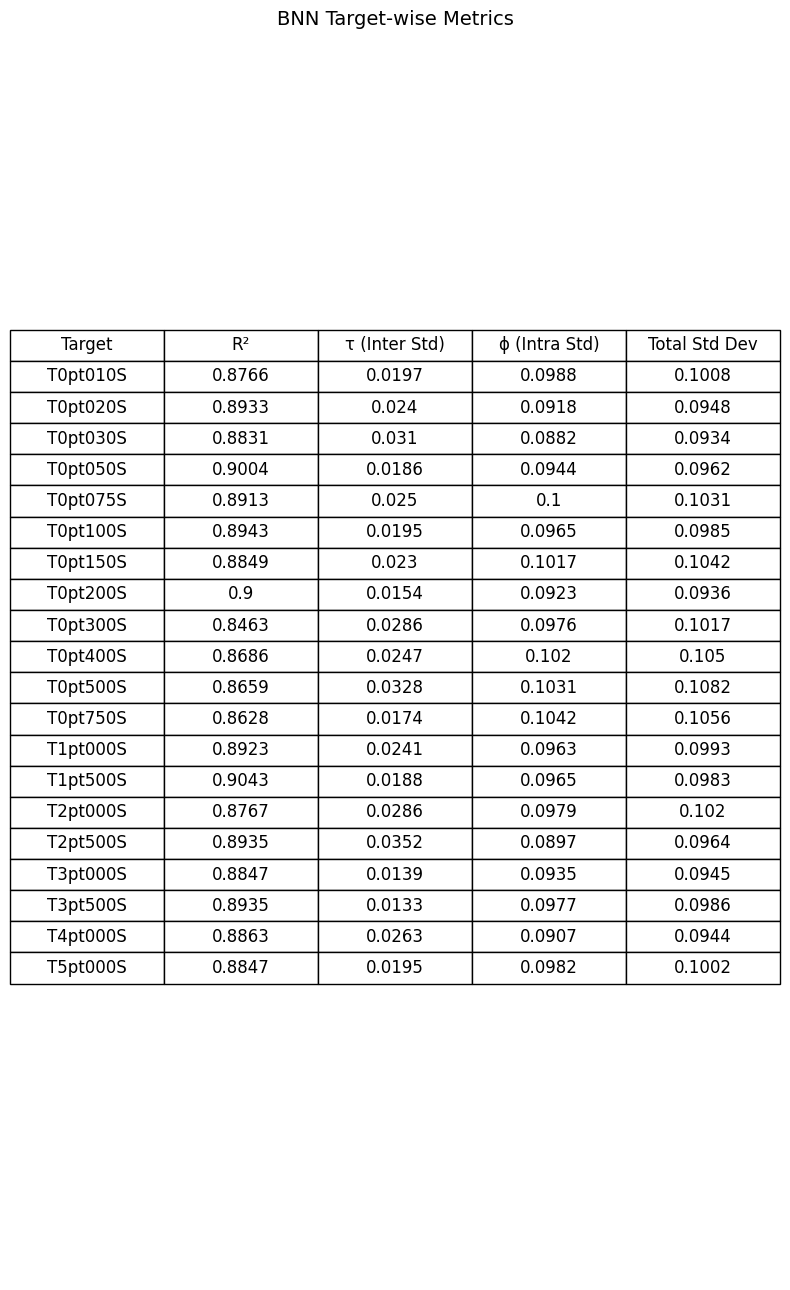

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

# Replace with your true and predicted values
# Example:
# y_test: numpy array (num_samples, num_targets)
# y_pred: numpy array (num_samples, num_targets)
# target_columns: list of target column names like ['T0pt', 'T1pt', ...]

# Dummy placeholders for this example (replace with actual values)
target_columns = [
    "T0pt010S", "T0pt020S", "T0pt030S", "T0pt050S", "T0pt075S",
    "T0pt100S", "T0pt150S", "T0pt200S", "T0pt300S", "T0pt400S",
    "T0pt500S", "T0pt750S", "T1pt000S", "T1pt500S", "T2pt000S",
    "T2pt500S", "T3pt000S", "T3pt500S", "T4pt000S", "T5pt000S"
]
y_test = np.random.rand(200, len(target_columns))
y_pred = y_test + np.random.normal(0, 0.1, y_test.shape)

# Optional: event_ids for inter/intra event std dev
# event_ids should be a 1D array of length y_test.shape[0] indicating event label
event_ids = np.random.randint(0, 10, size=y_test.shape[0])

# Calculate metrics
results = []
for i, col in enumerate(target_columns):
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    residuals = y_test[:, i] - y_pred[:, i]

    # Inter-event std (τ) and Intra-event std (ϕ)
    df = pd.DataFrame({'residuals': residuals, 'event': event_ids})
    inter_event_std = df.groupby('event').mean()['residuals'].std()       # τ
    intra_event_std = df.groupby('event').std()['residuals'].mean()       # ϕ
    total_std = np.sqrt(inter_event_std**2 + intra_event_std**2)

    results.append([col, r2, inter_event_std, intra_event_std, total_std])

# Create DataFrame
results_df = pd.DataFrame(results, columns=['Target', 'R²', 'τ (Inter Std)', 'ϕ (Intra Std)', 'Total Std Dev'])

# Display as table using matplotlib
def plot_table(df):
    fig, ax = plt.subplots(figsize=(8, 0.6 * len(df) + 1))
    ax.axis('off')

    # Convert numeric columns to strings with desired rounding
    numeric_cols = df.columns[1:]  # Exclude the 'Target' column
    df[numeric_cols] = df[numeric_cols].apply(lambda x: pd.Series(np.round(x, 4), index=x.index))

    tbl = ax.table(cellText=df.values,
                   colLabels=df.columns,
                   cellLoc='center',
                   loc='center')
    tbl.scale(1, 1.5)
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(12)
    plt.title("BNN Target-wise Metrics", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_table(results_df)

# Optional: Save as image
# fig.savefig("bnn_metrics_table.png", dpi=300)

##4) Netwrok Architecture

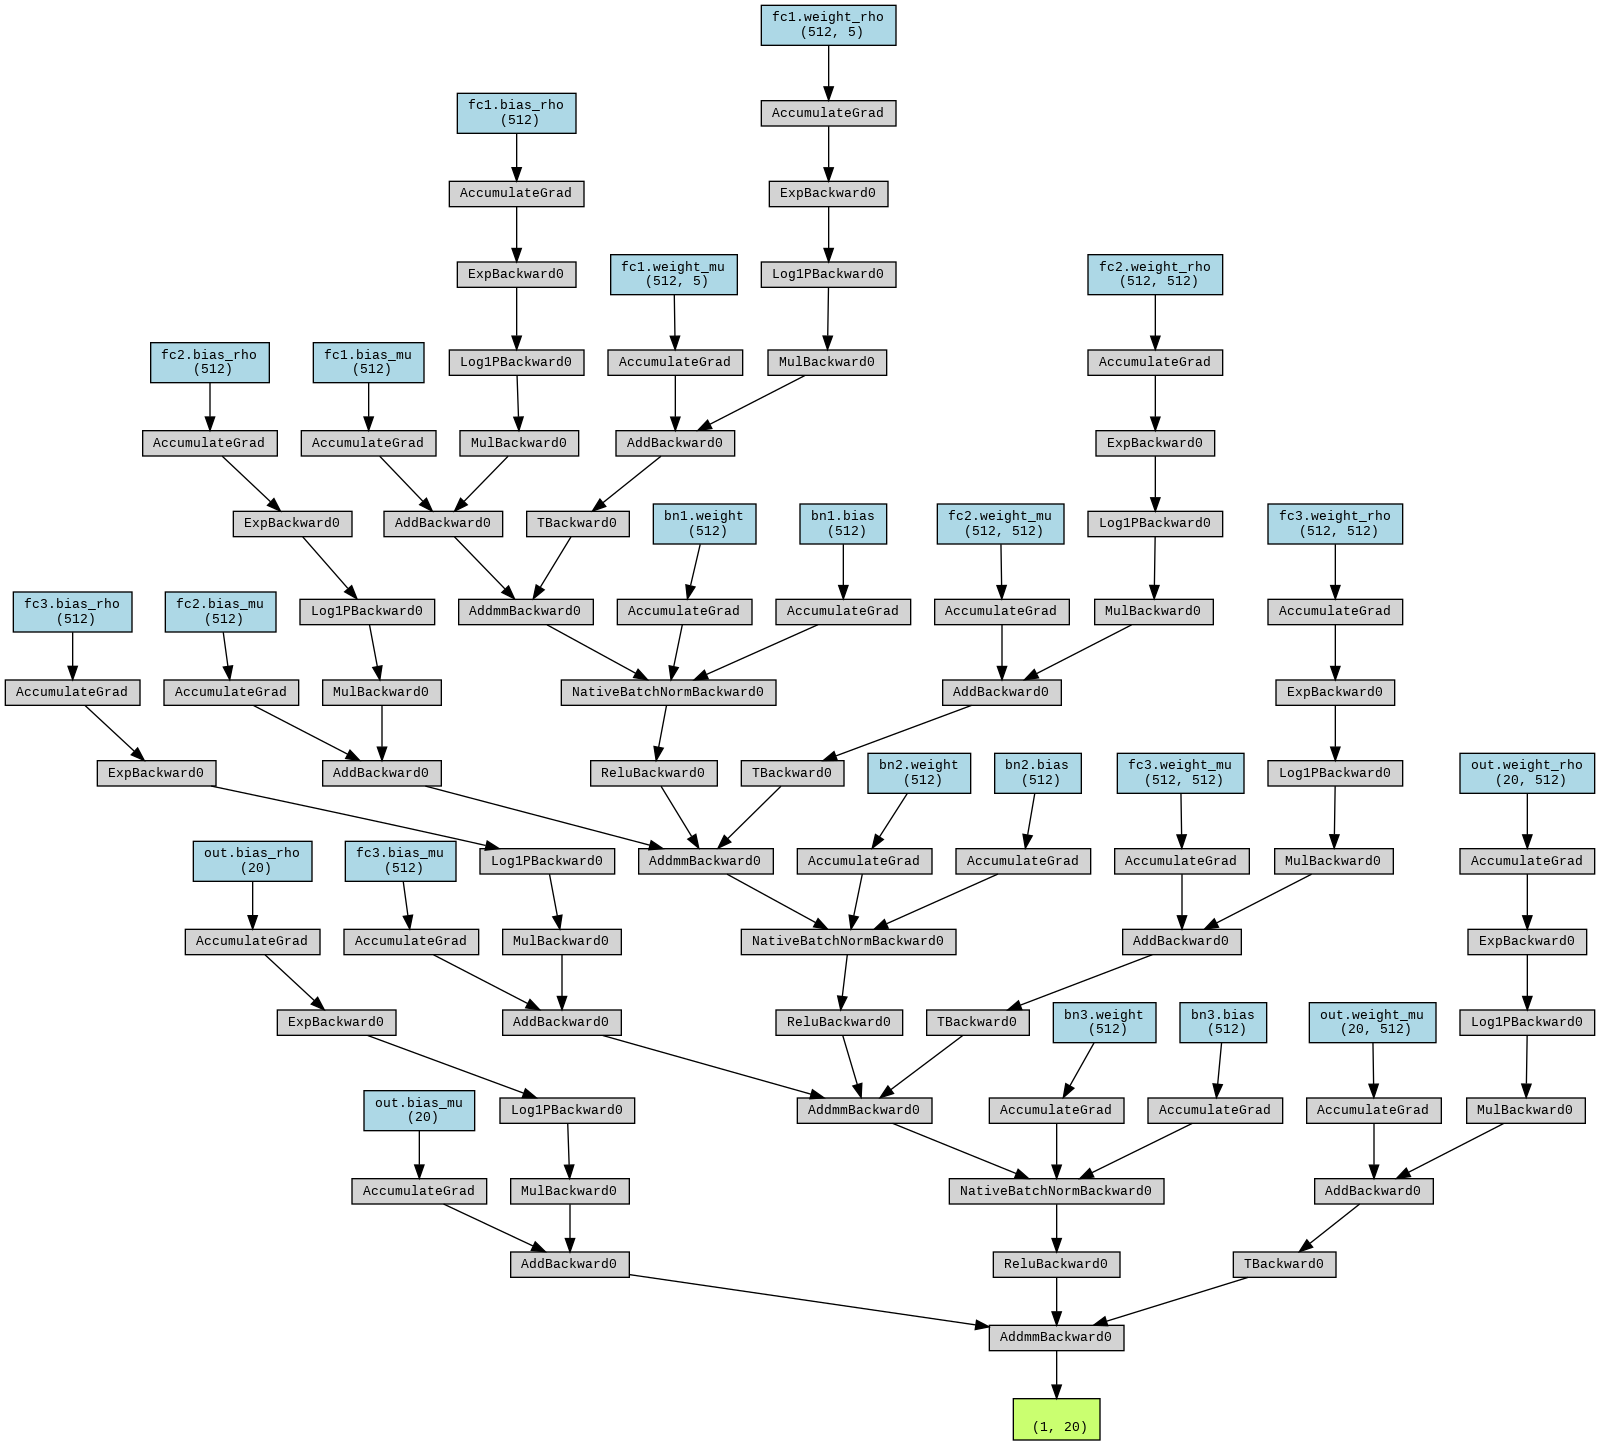

In [ ]:
!pip install torchviz
from torchviz import make_dot

# Pass a dummy input through the model
dummy_input = torch.randn(1, X_train.shape[1])
output = model(dummy_input)

# Create and display the graph
make_dot(output, params=dict(model.named_parameters())).render("bnn_architecture", format="png")
from IPython.display import Image
Image(filename="bnn_architecture.png")



##Table 1

In [ ]:
import pandas as pd
from scipy.stats import skew, kurtosis

# Create DataFrame for input features
# Use the correct number of columns based on X_train
df_input = pd.DataFrame(X_train, columns=['mag', 'rjb', 'logrjb', 'logvs30', 'intra_inter'])

# Compute statistics
summary_stats = pd.DataFrame({
    "Min": df_input.min(),
    "Max": df_input.max(),
    "Mean": df_input.mean(),
    "Std Dev": df_input.std(),
    "Skewness": df_input.apply(skew),
    "Kurtosis": df_input.apply(kurtosis)
})

# Round for readability
summary_stats = summary_stats.round(4)

# Display the table
print(summary_stats)

                 Min     Max  Mean  Std Dev  Skewness  Kurtosis
mag          -2.7242  2.2819  -0.0      1.0    0.7859    0.3906
rjb          -1.4710  3.6013   0.0      1.0    1.2926    1.5350
logrjb      -11.7792  1.7529   0.0      1.0   -3.3307   33.8885
logvs30      -4.2637  3.7293   0.0      1.0   -0.0870    0.1169
intra_inter  -0.8566  1.1674   0.0      1.0    0.3107   -1.9035


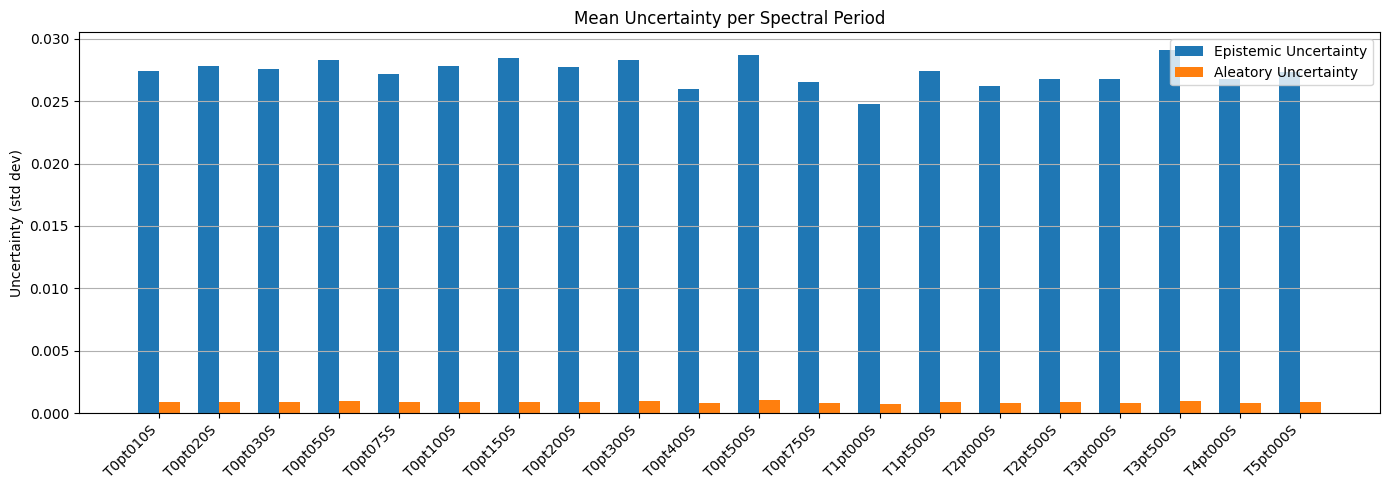

In [ ]:
# Convert tensors to numpy
epistemic_mean = epistemic_unc.mean(axis=0).numpy()
aleatory_mean = aleatory_unc.mean(axis=0).numpy()

x_labels = target_cols

x = np.arange(len(x_labels))
width = 0.35

plt.figure(figsize=(14, 5))
plt.bar(x - width/2, epistemic_mean, width, label='Epistemic Uncertainty')
plt.bar(x + width/2, aleatory_mean, width, label='Aleatory Uncertainty')
plt.xticks(ticks=x, labels=x_labels, rotation=45, ha='right')
plt.ylabel("Uncertainty (std dev)")
plt.title("Mean Uncertainty per Spectral Period")
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()


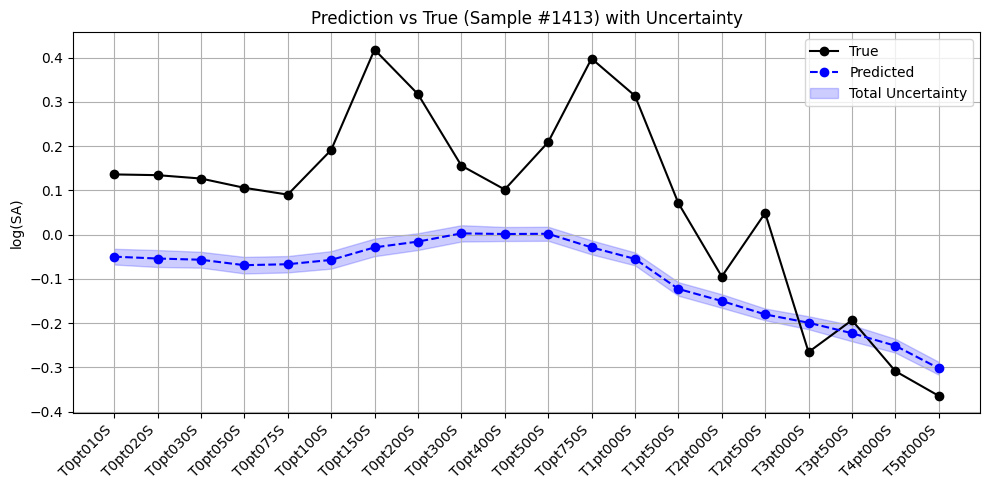

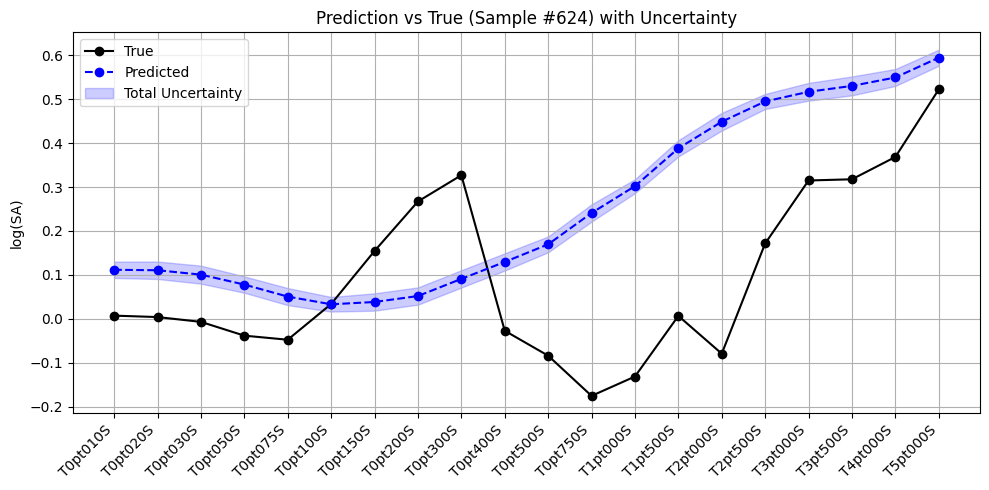

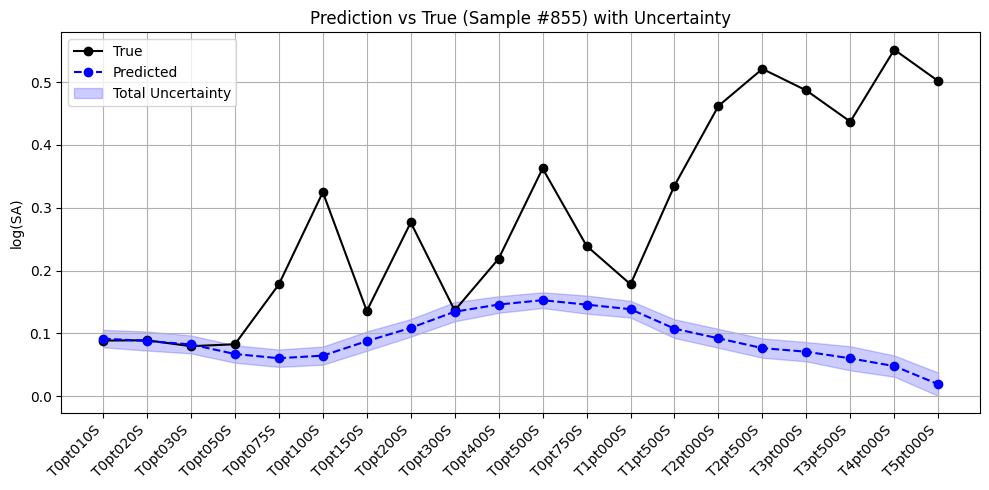

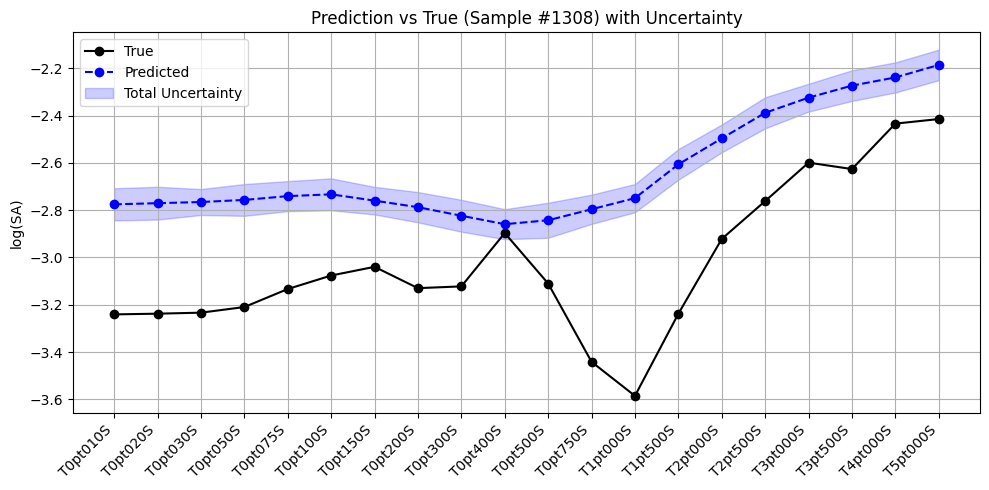

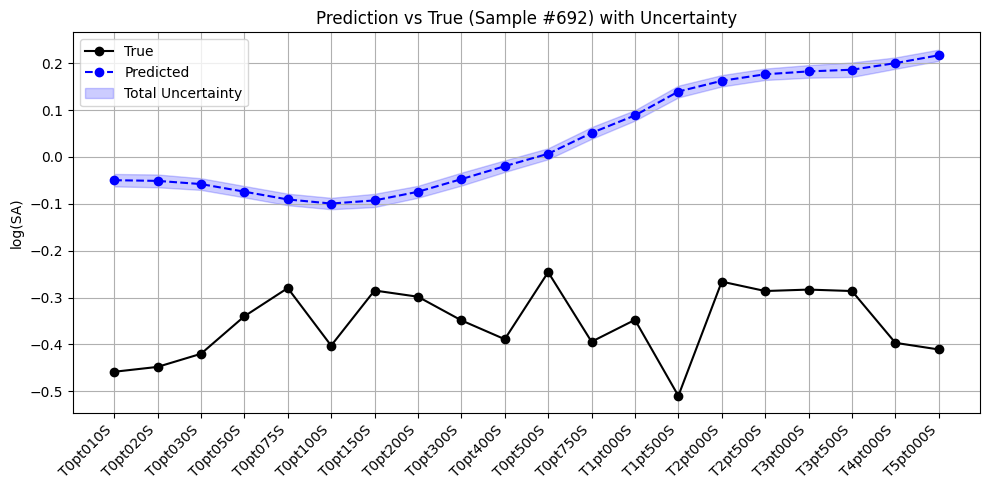

In [ ]:
def plot_predictions_with_uncertainty(y_true, y_pred, epistemic, aleatory, target_cols, num_samples=5):
    idxs = np.random.choice(len(y_true), size=num_samples, replace=False)
    time_periods = np.arange(len(target_cols))

    for idx in idxs:
        true_vals = y_true[idx]
        pred_vals = y_pred[idx]
        epi = epistemic[idx]
        alea = aleatory[idx]

        total_uncertainty = np.sqrt(epi**2 + alea**2)

        plt.figure(figsize=(10, 5))
        plt.plot(time_periods, true_vals, 'k-o', label='True')
        plt.plot(time_periods, pred_vals, 'b--o', label='Predicted')
        plt.fill_between(time_periods, pred_vals - total_uncertainty,
                         pred_vals + total_uncertainty, color='blue', alpha=0.2,
                         label='Total Uncertainty')
        plt.xticks(time_periods, target_cols, rotation=45, ha='right')
        plt.ylabel("log(SA)")
        plt.title(f"Prediction vs True (Sample #{idx}) with Uncertainty")
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.show()

# Call the function
plot_predictions_with_uncertainty(Y_test_tensor.numpy(), mean_pred.numpy(),
                                  epistemic_unc.numpy(), aleatory_unc.numpy(),
                                  target_cols, num_samples=5)
